<a href="https://colab.research.google.com/github/wicky818/UTKFace_Deep_Learning/blob/main/UTKFace_DeepLearning_Gender_Predictions_Exploratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wandb -q
!pip install tensorflow==2.7.0

     |████████████████████████████████| 1.8 MB 4.2 MB/s 
     |████████████████████████████████| 145 kB 73.2 MB/s 
     |████████████████████████████████| 181 kB 57.0 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     \ 665.5 MB 391 kB/s
     |████████████████████████████████| 463 kB 4.3 MB/s 
     |████████████████████████████████| 1.3 MB 33.8 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: tensorfl

In [2]:
! pip install keras-tuner --upgrade
import keras_tuner as kt
from tensorflow import keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 133 kB 4.1 MB/s 


# Getting Data

In [3]:
!git clone https://github.com/wicky818/UTKFace_Deep_Learning.git

Cloning into 'UTKFace_Deep_Learning'...
remote: Enumerating objects: 23353, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 23353 (delta 2), reused 0 (delta 0), pack-reused 23347
Receiving objects: 100% (23353/23353), 110.99 MiB | 13.52 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Checking out files: 100% (33492/33492), done.


In [4]:
!ls

sample_data  UTKFace_Deep_Learning


In [5]:
import os

os.chdir("/content/UTKFace_Deep_Learning")
images = os.listdir('/content/UTKFace_Deep_Learning/dataset/UTKFace')
print('Total number of images: ', len(images))

Total number of images:  23708


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [7]:
import datetime
import time
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

# Loading Data

[age] is an integer from 0 to 116, indicating the age\
[gender] is either 0 (male) or 1 (female)\
[race] is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).\
[date&time] is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace

In [8]:
images = []
ages = []
genders = []
race = []

for i in os.listdir('/content/UTKFace_Deep_Learning/dataset/UTKFace')[0:10000]:
    split = i.split('_')
    ages.append((split[0]))
    genders.append((split[1]))
    race.append((split[2]))

    images.append(Image.open('/content/UTKFace_Deep_Learning/dataset/UTKFace/' + i))

In [9]:
images = pd.Series(list(images), name = 'Images')
ages = pd.Series(list(ages), name = 'Ages')
genders = pd.Series(list(genders), name = 'Genders')
race = pd.Series(list(race), name = 'Races')

df = pd.concat([images, ages, genders, race], axis=1)

In [10]:
df["Races"].unique()

array(['0', '3', '2', '1', '4', '20170116174525125.jpg.chip.jpg'],
      dtype=object)

In [11]:
# Cleanup bad data points without "Races"

df.drop(df[df["Races"] == "20170116174525125.jpg.chip.jpg"].index, inplace = True)
df.drop(df[df["Races"] == '20170109142408075.jpg.chip.jpg'].index, inplace = True)
df.drop(df[df["Races"] == '20170109150557335.jpg.chip.jpg'].index, inplace = True)

In [12]:
df['Ages'] = df['Ages'].astype(int)
df['Genders'] = df['Genders'].astype(int)
df['Races'] = df['Races'].astype(int)

In [13]:
df["Races"].unique()

array([0, 3, 2, 1, 4])

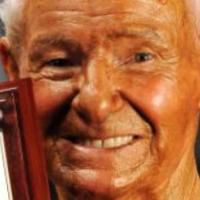

78 0 0


In [14]:
display(df['Images'][0])
print(df['Ages'][0], df['Genders'][0], df['Races'][0])

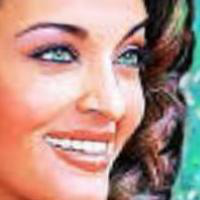

27 1 3


In [15]:
display(df['Images'][1])
print(df['Ages'][1], df['Genders'][1], df['Races'][1])

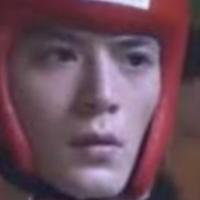

23 0 2


In [16]:
display(df['Images'][2])
print(df['Ages'][2], df['Genders'][2], df['Races'][2])

# Exploratory Data Analysis

In [17]:
df.head()

,Images,Ages,Genders,Races
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,78,0,0
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,27,1,3
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,23,0,2
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,39,0,0
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,54,0,0


In [18]:
df.Races.unique()

array([0, 3, 2, 1, 4])

In [19]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


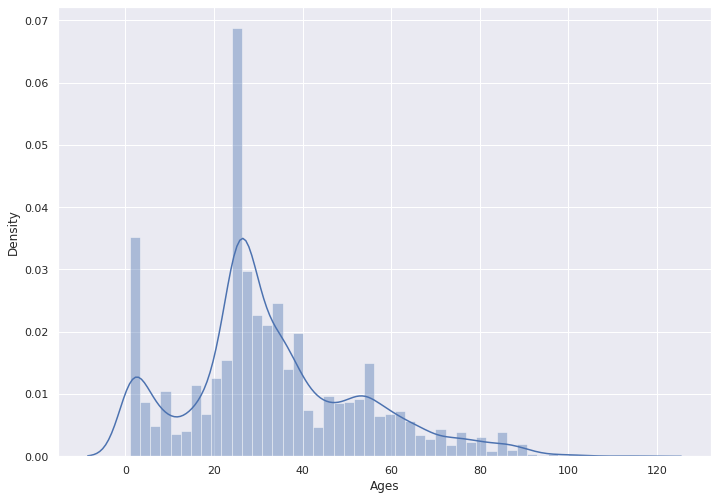

In [20]:
sns.distplot(df["Ages"])

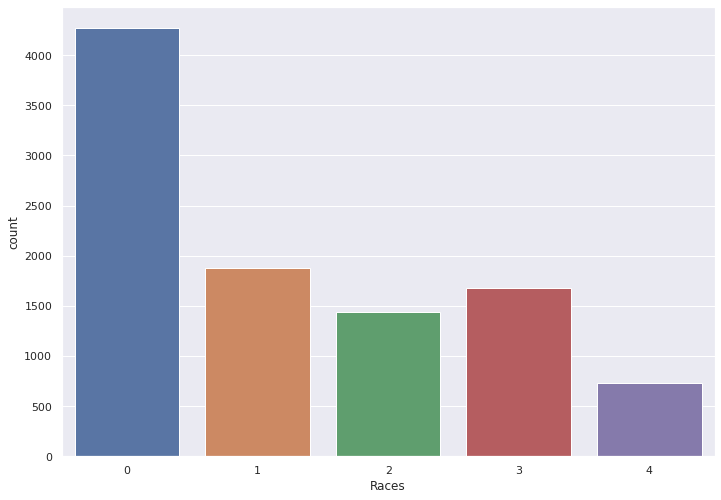

In [21]:
sns.countplot(x = "Races", data = df)

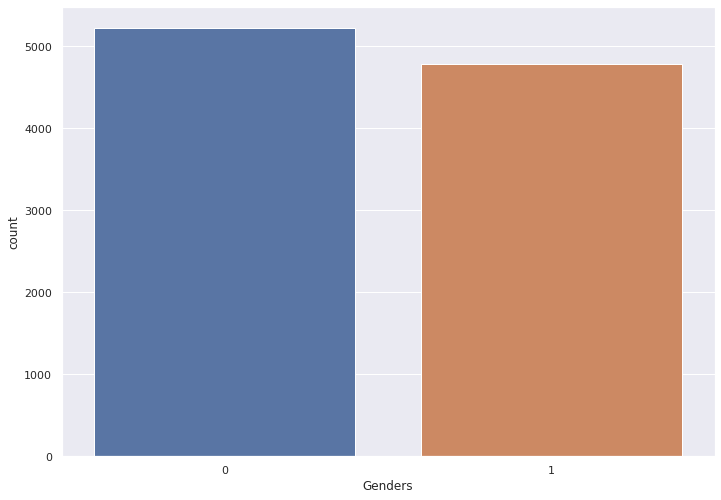

In [22]:
sns.countplot(x = "Genders", data = df)

# Age Prediction

In [23]:
df.shape

(9999, 4)

In [24]:
x = []
y = []

for i in range(len(df)):
    df['Images'].iloc[i] = df['Images'].iloc[i].resize((200,200), Image.ANTIALIAS)
    ar = np.asarray(df['Images'].iloc[i])
    x.append(ar)
    agegen = [int(df['Ages'].iloc[i]), int(df['Genders'].iloc[i]), int(df['Races'].iloc[i])]
    y.append(agegen)
x = np.array(x)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [25]:
x.shape

(9999, 200, 200, 3)

In [26]:
len(y)

9999

In [27]:
df.to_csv("data.csv", index=None)
np.save('file_name', x)

In [28]:
!git clone https://github.com/wicky818/UTKFace_Deep_Learning/dataset.git
!cd dataset.git

fatal: destination path 'dataset' already exists and is not an empty directory.
/bin/bash: line 0: cd: dataset.git: No such file or directory


In [29]:
y_age = df['Ages']
y_gender = df['Genders']
y_race = df['Races']

x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(x, y_age, test_size=0.2, random_state=85)
x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(x, y_gender, test_size=0.2, random_state=85)
x_train_race, x_test_race, y_train_race, y_test_race = train_test_split(x, y_race, test_size=0.2, random_state=85)

In [30]:
y_train_age.shape

(7999,)

x_train_age.shape

In [31]:
x_train_age.shape

(7999, 200, 200, 3)

In [32]:
y_train_age

4763    35
2459    23
1516    40
1806    37
1964    52
        ..
1574    14
5716    87
6709    38
1588    26
4459    31
Name: Ages, Length: 7999, dtype: int64

In [33]:
x_train_age = x_train_age.astype(int)

# Modeling


# Gender Model

In [34]:
def build_model(hp):  
  model = keras.Sequential([
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        input_shape=(200,200,3)
    ),
    MaxPooling2D((2,2)),
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu'
    ),
    MaxPooling2D((2,2)),
    keras.layers.Conv2D(
        filters=hp.Int('conv_3_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_3_kernel', values = [3,5]),
        activation='relu'
    ),
    MaxPooling2D((2,2)),

    keras.layers.Flatten(),
    BatchNormalization(),

    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    Dropout(0.5),

    keras.layers.Dense(1, activation='sigmoid')
  ])
  model.compile(optimizer=keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])
  
  return model

In [35]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  """Entry point for launching an IPython kernel.


In [36]:
tuner_search=RandomSearch(build_model,
                          objective='val_accuracy',
                          max_trials=5,directory='output',project_name="UTK_Face_Gender")

In [37]:
datagen = ImageDataGenerator(
      rescale=1./255., width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

x_train_mod_gender,x_val_gender, y_train_mod_gender, y_val_gender = train_test_split(x_train_gender, y_train_gender, test_size=0.2, random_state=85)

test_datagen = ImageDataGenerator(rescale=1./255)

train2 = datagen.flow(x_train_mod_gender, y_train_mod_gender, batch_size=32)

test2 = test_datagen.flow(
        x_val_gender, y_val_gender,
        batch_size=32)


history1 = tuner_search.search(train2, epochs=10, validation_data = test2)


Trial 5 Complete [00h 08m 32s]
val_accuracy: 0.8218749761581421

Best val_accuracy So Far: 0.8356249928474426
Total elapsed time: 00h 43m 12s
INFO:tensorflow:Oracle triggered exit


In [38]:
history1

In [39]:
model=tuner_search.get_best_models(num_models=1)[0]

In [40]:
model.summary()
!mkdir -p saved_model
model.save('saved_model/my_model') 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 48)      1344      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 48)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        27712     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 48)        27696     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 48)       0

In [48]:
!cp -r "/content/UTKFace_Deep_Learning/saved_model" "/content/drive/MyDrive/UTKFace"

In [45]:
new_model = tf.keras.models.load_model('model/saved_model')

# Check its architecture
new_model.summary()a

OSError: ignored

In [ ]:
datagen = ImageDataGenerator(
      rescale=1./255., width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

x_train_mod_gender,x_val_gender, y_train_mod_gender, y_val_gender = train_test_split(x_train_gender, y_train_gender, test_size=0.2, random_state=85)

test_datagen = ImageDataGenerator(rescale=1./255)

train2 = datagen.flow(x_train_mod_gender, y_train_mod_gender, batch_size=32)

test2 = test_datagen.flow(
        x_val_gender, y_val_gender,
        batch_size=32)

history1 = model.fit(train2, epochs=50, shuffle=True, validation_data = test2, 
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)])

Epoch 1/50


In [49]:
loss, accuracy = model.evaluate(x_test_gender, y_test_gender)
print('test set accuracy: ', accuracy * 100, "%")

63/63 [==============================] - 1s 18ms/step - loss: 1418.8367 - accuracy: 0.5195
test set accuracy:  51.95000171661377 %


In [50]:
train_losses = history1.history["loss"]
train_accs = history1.history["accuracy"]
val_losses = history1.history["val_loss"]
val_accs = history1.history["val_accuracy"]
epochs = len(train_losses)

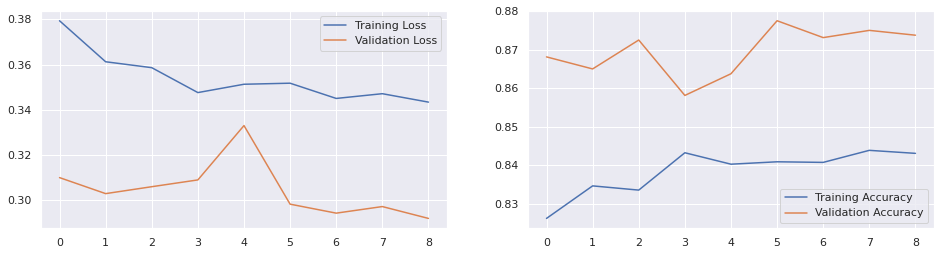

In [51]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([train_losses, train_accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()